In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(
    "DATA/data.csv",
    encoding="cp1252",
    engine="python"
)

x = df["no2"]
x = x.dropna()
x = pd.to_numeric(x, errors="coerce")
x = x.dropna()
x = x.values

print("Total samples:", len(x))
print("Mean of x:", np.mean(x))
print("Std of x:", np.std(x))

r = 102303592

a_r = 0.05 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r:", a_r)
print("b_r:", b_r)

z = x + a_r * np.sin(b_r * x)

print("Mean of z:", np.mean(z))
print("Std of z:", np.std(z))

Total samples: 419509
Mean of x: 25.80962289781127
Std of x: 18.503064345501244
a_r: 0.30000000000000004
b_r: 0.8999999999999999
Mean of z: 25.801325453003013
Std of z: 18.513509719601263


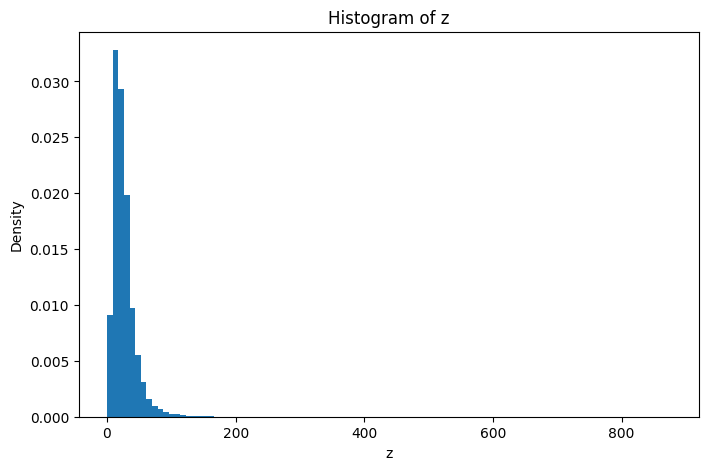

In [3]:
plt.figure(figsize=(8,5))
plt.hist(z, bins=100, density=True)
plt.title("Histogram of z")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()